# Classical Analysis

First, let's import the packages we will use including numpy and matplotlib. 

Then, let's import our functions we will be using that handles the solve methods. 

`kepler_d_hamiltonian` returns functions for the partial derivatives of the kepler hamiltonian.

`plot_orbit` returns the coordinate solutions, and plots the coordinates. 

`find_major_axis` determines the period of orbit and semi major axis distance for a set of coordinate solutions.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from proj_1_module import dynamics_solve, hamiltonian_solve
from proj_1_ClassicalAnalysis import kepler_d_hamiltonian, plot_orbit, find_major_axis

%matplotlib inline

## Two Body Orbital Mechanics

- Pick whichever algorithm you believe will yield the most accurate results for the orbital dynamics problem, and determine an appropriate step size that gives reliable results.  Comment on how you chose that step size.
- Use simulations to show that the classical dynamics model of the two-body problem predicts Kepler's Third Law.
- Make sure to check conservation of any relevant conserved quantities as a check on the correctness of your simulations.
- Find reliable data online (cite your source) that give you initial conditions for the orbit of the Earth, and simulate its orbit for 10000 cycles using whichever algorithm you think is most appropriate.  Justify which algorithm you used to simulated a large number of periods.  Explain why you believe it will give reliable results on long time scales, and comment on how you know (what aspects of the simulation results have you checked?) your simulation is reasonably accurate.

### Choose which method to use

In most cases, the two body central force problem is solved using a Hamiltonian or Lagrangian. Therefore, I will use the `hamiltonian_solve` method. 

From our previous tests in `proj_1_DynamicsTest`, we found that the symplectic methods produced more accurate solutions for the same parameters as the RK methods. Therefore, I will use the symplectic methods to solve this problem. 

We also found that the SE and SV methods produce nearly identical results. Since SV has one more computation step, and we will be calculating many cycles, I will chose the SE method for computational efficiency. 

### Initial Parameters

In this project, we want to simulate Earth's orbit around the sun. So, let's define the parameters we will use. I will express everything in SI units. 

$$m_{Earth} = 5.972 \times 10 ^ {24} kg$$
$$m_{Sun} = 1.989 \times 10 ^ {30} kg$$

$$ G = 6.674 \times 10 ^ {-11} \frac{m^2}{kg\cdot s^2}$$

$$k = G * m_{Sun} * m_{Earth}$$

$$\mu = \frac{1}{m_{Sun}} + \frac{1}{m_{Earth}}$$

We also need initial conditons for position $q_0$ and momentum $p_0$. I will use the distance from the Earth to the Sun, and Earth's orbital velocity at Aphelion, the furthest point from the sun. These values can be found [here](https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html). 

The Aphelion distance is $152.10\times 10 ^ {9} m$, and orbital velocity is $29.290 \times 10 ^ {3}\frac{m}{s}$.

$$q_0 = (152.10 \times 10 ^ {9}, 0 )$$
$$p_0 = (0, 29290 * \mu )$$

Where $q_0$ is in meters, and $p_0$ is in $\frac{kg \cdot m}{s}$. 

Note: Since $m_{Sun} \gg  m_{Earth}$, I am making an approximation and using Earth's initial conditons for the CoM system. 

### Step Size

Since I am using SI units, a step size of $h = 1$ is one second. While this is considered a small step size, there are about $3.15\times 10 ^ {7}$ seconds in a year. If we want to calculate the orbit for many years, the number of calculations becomes excessive. 

From Dynamics Test, we found that a step size of $\frac{1}{100}$ one period was sufficently accurate. So, lets choose a step size of one day, or 86,400 seconds. So, $h = 86400$.

If we ever need to calculate more accurate results over long time scales, we can decrease $h$ at the cost of computation time. 

### Kepler's Third Law

Kepler's Third Law states "The period of the orbit $T$ is proportional to $a^{3/2}$, where $a$ is the semi-major axis of the ellipse."

We can verify this by measuring the orbit period $T$ and semi-major axis $a$ for multiple different parameters. 

First, we must create a method to determine the period and semi-major axis from our solution data. 

Here is an example plotting Earth's orbit for one year. 

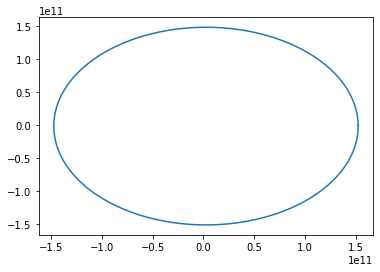

In [2]:
# Define using earth masses
m_sun = 1.989e30
m_earth = 5.972e24
d_qH, d_pH, m, k = kepler_d_hamiltonian(m_sun, m_earth)

# Set initial conditions
# Consider coordinates at Aphelion
# https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html
q_0 = np.array([152.10e9, 0])
p_0 = np.array([0, 29290 * m])

# Solve system
t, q, p = hamiltonian_solve(d_qH, d_pH, d = 2, t_0 = 0.0, q_0 = q_0, p_0 = p_0, h = 86400, N = 365, method = "SE")

# Assume that Earth's coordinates are roughly equal to CoM coordinates since m_sun >> m_earth. 
# Unpack (x, y) coordinates to be plotted using matplotlib
x, y = q.T

plt.plot(x, y)
plt.show()

<sub><sub><sub>Okay, so I actually hate matplotlib with a passion, so the aspect ratio isn't equal. The workaround I tried gives warnings, and I am not sure the proper way to do it. So, we will deal with a squashed plot. </sub></sub></sub>


Yay, we have a full and complete orbit of the Earth around the Sun for a period of one year. 

Now the question is, "how do we determine the period and semi-major axis from a set of coordinate points?"

The semi-major axis is half the distance from one long end to the other. Since I chose the initial paremeters to be at Aphelion, the distance from the initial point to the position one-half period later is the major axis. 

Therefore, I can identify the points when the y-coordinate switches sign, as it passes through the x-axis on our plot. These points represent the two points along the major axis. 

The period can be determined when the y-coordinate switches back to positive, as this represents one full orbit. Since we know that the SE method's period accuracy decays over time, I will only determine these points for the first orbit. 

The method `find_major_axis` handles this calculation. 

Now let's calculate the period and semi-major axis for all of the planets. I am using planetary data from [this source](https://nssdc.gsfc.nasa.gov/planetary/factsheet/). 

In [3]:
m_sun = 1.989e30

planets = [
	{"name": "Mercury", "mass": 0.33011e24, "aphelion": 69.82e9, "veloc": 38.86e3, "N": 1000},
	{"name": "Venus", "mass": 4.8675e24, "aphelion": 108.94e9, "veloc": 34.79e3, "N": 1000},
	{"name": "Earth", "mass": 5.9724e24, "aphelion": 152.10e9, "veloc": 29.29e3, "N": 1000},
	{"name": "Mars", "mass": 0.64171e24, "aphelion": 249.23e9, "veloc": 21.97e3, "N": 1000},
	{"name": "Jupiter", "mass": 1898.19e24, "aphelion": 816.62e9, "veloc": 12.44e3, "N": 5000},
	{"name": "Saturn", "mass": 568.34e24, "aphelion": 1514.50e9, "veloc": 9.09e3, "N": 20000},
	{"name": "Uranus", "mass": 86.813e24, "aphelion": 3003.62e9, "veloc": 6.49e3, "N": 50000},
	{"name": "Neptune", "mass": 102.413e24, "aphelion": 4545.67e9, "veloc": 5.37e3, "N": 100000},
	{"name": "Pluto", "mass": 0.01303e24, "aphelion": 7375.93e9, "veloc": 3.71e3, "N": 100000}
]

for planet in planets: 
	print(f"Calculating orbit for {planet['name']}...")
	m = m_sun * planet["mass"] / (m_sun + planet["mass"])
	q_0 = np.array([planet["aphelion"], 0])
	p_0 = np.array([0, planet["veloc"] * m])
	period, semi_major_length = find_major_axis(m_sun, planet["mass"], q_0, p_0, h = 86400, N = planet["N"])
	planet["period"] = period
	planet["semi_major_length"] = semi_major_length

Calculating orbit for Mercury...
Calculating orbit for Venus...
Calculating orbit for Earth...
Calculating orbit for Mars...
Calculating orbit for Jupiter...
Calculating orbit for Saturn...
Calculating orbit for Uranus...
Calculating orbit for Neptune...
Calculating orbit for Pluto...


Now that we have calculated the period and semi-major axis for a good sample size, let's verify Kepler's Third Law. If it is true that $T$ is proportional to $a^{3/2}$, then if we plot $T$ vs. $a^{3/2}$, the points should form a linear relationship. 

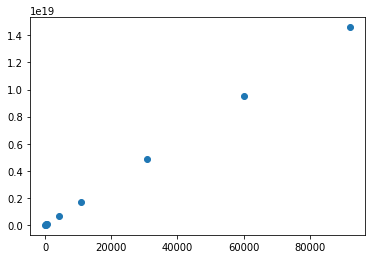

In [4]:
periods = [planet["period"]/86400 for planet in planets]
semi_axis = [planet["semi_major_length"] ** (3/2) for planet in planets]

plt.scatter(periods, semi_axis)
plt.show()

And would you look at that, a linear plot! 

Therefore, our numerical calculations verify Kepler's Third Law. 

### Conservation of conserved quantities

We know that for a two body orbital system, the energy and angular momentum should be constant in time. Let's double check that this is the case with our solutions. 

Let's check Earth's orbit. Again, using initial conditions found [here](https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html). 

Recall that $E = \frac{p^2}{2 \mu } - \frac{k}{r}$ and $L = q \times p$.

Let's plot the energy and angular momentum as a function of time for 10,000 years. For this, I will use the SE method for reasons described earlier. 

NOTE: THIS CALCULATION WILL TAKE A LONG TIME

Actually, it is taking way too long. 10,000 years of calculations is just too much. I really don't think this is necessary. Let's do 100 years instead. 

Calculating... 8.08%

Calculating... 11.77%

Calculating... 16.29%

Calculating... 18.49%

Calculating... 20.4%

Calculating... 27.73%

Calculating... 29.53%

Calculating... 32.35%

Calculating... 38.2%

Calculating... 43.67%

Calculating... 48.9%

Calculating... 53.26%

Calculating... 60.67%

Calculating... 62.84%

Calculating... 71.05%

Calculating... 76.53%

Calculating... 82.01%

Calculating... 87.48%

Calculating... 92.96%

Calculating... 97.08%

Calculating... 98.87%

Calculating... 100.0%


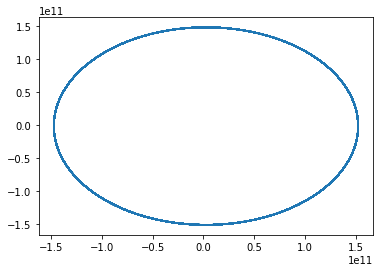

In [5]:
m_sun = 1.989e30
m_earth = 5.972e24
m = m_sun * m_earth / (m_sun + m_earth)
q_0 = np.array([152.10e9, 0])
p_0 = np.array([0, 29290 * m])
years = 100
x, y, px, py = plot_orbit(m_sun, m_earth, q_0, p_0, h = 86400, N = 365*years, method = "SE", display_plot = True, verbose = True)

# I added a percent progress bar. It displays properly in the terminal, but not in Jupyter Notebooks. It is JN fault, not mine. 

In [6]:
def calculate_energy(x, y, px, py, m_1, m_2):
	m = m_1 * m_2 / (m_1 + m_2)
	g = 6.67408e-11
	k = g * m_1 * m_2
	q = (x ** 2 + y ** 2) ** 0.5
	p = (px ** 2 + py ** 2) ** 0.5
	return ((p ** 2) / (2 * m)) - (k / q)

def calculate_ang_momentum(x, y, px, py):
	q = (x ** 2 + y ** 2) ** 0.5
	p = (px ** 2 + py ** 2) ** 0.5
	return q * p

In [7]:
energy = []
ang_momentum = []
for i in range(len(x)):
	print(f"Calculating Energy... {round(100*i/(365*years), 2)}%", end = "\r")
	energy.append(calculate_energy(x[i], y[i], px[i], py[i], m_sun, m_earth))
print()
for i in range(len(x)):
	print(f"Calculating Angular Momentum... {round(100*i/(365*years), 2)}%", end = "\r")
	ang_momentum.append(calculate_ang_momentum(x[i], y[i], px[i], py[i]))
print()

Calculating Energy... 5.24%

Calculating Energy... 10.72%

Calculating Energy... 16.2%

Calculating Energy... 21.67%

Calculating Energy... 27.15%

Calculating Energy... 32.63%

Calculating Energy... 37.37%

Calculating Energy... 39.97%

Calculating Energy... 46.78%

Calculating Energy... 49.81%

Calculating Energy... 53.32%

Calculating Energy... 61.38%

Calculating Energy... 66.85%

Calculating Energy... 76.44%

Calculating Energy... 81.92%

Calculating Energy... 87.39%

Calculating Energy... 92.87%

Calculating Energy... 98.35%

Calculating Energy... 100.0%


Calculating Angular Momentum... 3.46%

Calculating Angular Momentum... 8.7%

Calculating Angular Momentum... 11.24%

Calculating Angular Momentum... 16.12%

Calculating Angular Momentum... 18.55%

Calculating Angular Momentum... 25.72%

Calculating Angular Momentum... 31.2%

Calculating Angular Momentum... 36.68%

Calculating Angular Momentum... 40.78%

Calculating Angular Momentum... 46.26%

Calculating Angular Momentum... 49.04%

Calculating Angular Momentum... 51.74%

Calculating Angular Momentum... 57.21%

Calculating Angular Momentum... 62.69%

Calculating Angular Momentum... 65.11%

Calculating Angular Momentum... 72.27%

Calculating Angular Momentum... 77.75%

Calculating Angular Momentum... 83.23%

Calculating Angular Momentum... 88.7%

Calculating Angular Momentum... 94.21%

Calculating Angular Momentum... 100.0%


<ipython-input-8-81873a28f831>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_ylim(top = -2e33, bottom = -3e33)


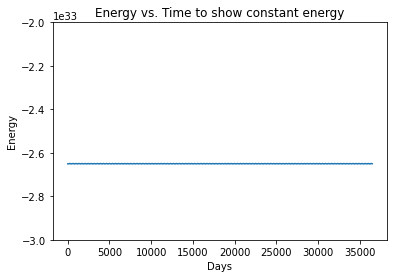

In [8]:
plt.plot(energy)
plt.axes().set_ylim(top = -2e33, bottom = -3e33)
plt.xlabel('Days')
plt.ylabel('Energy')
plt.title('Energy vs. Time to show constant energy')
plt.show()

<ipython-input-9-950d1bedd54e>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_ylim(top = 2e40, bottom = 3e40)


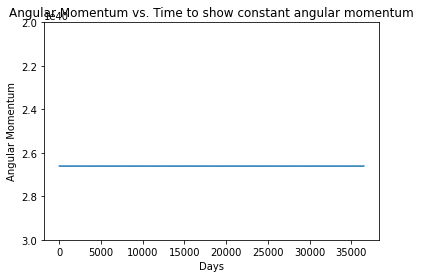

In [9]:
plt.plot(ang_momentum)
plt.axes().set_ylim(top = 2e40, bottom = 3e40)
plt.xlabel('Days')
plt.ylabel('Angular Momentum')
plt.title('Angular Momentum vs. Time to show constant angular momentum')
plt.show()

As we can see in the plots above, the energy and angular momentum both appear to be constant in time. Therefore, we can conclude that our energy and angular momentum are conserved in our numerical solutions, as they should be. 